# Clustering FakeNewsNet - PolitiFact content

___OBS:___ _The data examined in this notebook can be downloaded from [here](https://www.kaggle.com/datasets/mdepak/fakenewsnet?resource=download&select=PolitiFactUserFeature.mat)_

In [1]:
from pathlib import Path

import numpy as np
import networkx as nx
import netwulf as nw
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from tqdm import tqdm
tqdm.pandas()

import pandas as pd
pd.options.future.infer_string = True

In [2]:
from itertools import product
from collections import defaultdict


# Inspiration from ChatGPT
def get_tuple_combinations(list1, list2):
    combinations = [(item1, item2) for item1, item2 in product(list1, list2) if item1 != item2 and item1 < item2]
    return combinations

In [3]:
# Set path to data folder
DATA_DIR = Path(r"C:\Users\alber\Desktop\DTU\3_HCAI\02807\project\02807_CompTools_Project\data")

## Load data

In [4]:
# Load content of news data
fake_news   = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/PolitiFact_fake_news_content.csv', engine="pyarrow")
real_news   = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/PolitiFact_real_news_content.csv', engine="pyarrow")
df          = pd.concat([fake_news, real_news]).reset_index(drop=True)

df.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
0,Real_1-Webpage,Trump Just Insulted Millions Who Lost Everythi...,16.8k SHARES SHARE THIS STORY Hillary Clinton...,http://occupydemocrats.com/2016/09/27/trump-ju...,http://occupydemocrats.com/wp-content/uploads/...,"Brett Bose,Grant Stern,Steve Bernstein,Natalie...",http://occupydemocrats.com,{'$date': 1474934400000},NaN,http://occupydemocrats.com/wp-content/uploads/...,http://occupydemocrats.com/2016/09/27/trump-ju...,"{""generator"": ""Powered by Visual Composer - dr..."
1,Real_10-Webpage,Famous dog killed in spot she waited a year fo...,Famous dog killed in spot she waited a year fo...,http://rightwingnews.com/top-news/famous-dog-k...,http://rightwingnews.com/wp-content/uploads/20...,NaN,http://rightwingnews.com,{'$date': 1474948336000},NaN,http://rightwingnews.com/wp-content/uploads/20...,http://rightwingnews.com/top-news/famous-dog-k...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam..."
2,Real_100-Webpage,House oversight panel votes Clinton IT chief i...,Story highlights The House Oversight panel vot...,http://cnn.it/2deaH2d,http://i2.cdn.cnn.com/cnnnext/dam/assets/16091...,"Tom Lobianco,Deirdre Walsh",http://cnn.it,NaN,NaN,http://i2.cdn.cnn.com/cnnnext/dam/assets/17050...,http://www.cnn.com/2016/09/22/politics/bryan-p...,"{""description"": ""Members of the House Oversigh..."
3,Real_101-Webpage,America Just Tragically Lost A Country Music I...,We are absolutely heartbroken to hear about th...,http://newsbake.com/entertainment-news/music-e...,http://newsbake.com/wp-content/uploads/2016/05...,Nancy Wells,http://newsbake.com,{'$date': 1474898600000},https://www.youtube.com/embed/8ozTJcu-_BU,http://0.gravatar.com/avatar/0d702c6042933cd78...,http://newsbake.com/entertainment-news/music-e...,"{""shareaholic"": {""site_name"": ""NewsBake"", ""lan..."
4,Real_102-Webpage,Monuments to the Battle for the New South,"Nine years ago, a driver lost control of his p...",http://politi.co/2dd9U1x,http://static.politico.com/25/ed/85332de14c45b...,"Jack Shafer,Lisa Rab",http://politi.co,{'$date': 1473941820000},NaN,http://static.politico.com/25/ed/85332de14c45b...,http://www.politico.com/magazine/story/2016/09...,"{""description"": ""Virginia, increasingly divers..."


In [5]:
# Load social content data - i.e. user and news "interactions" 
newsId              = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/PolitiFactNews.txt', sep='\t', header=None)
userId              = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/PolitiFactUser.txt', sep='\t', header=None)

# Create index mappings
idx2newsId          = {i+1: key for i, key in enumerate(newsId[0])}
idx2userId          = {i+1: key for i, key in enumerate(userId[0])}

# Add real user and news ids/names to dataframe
NewsUser            = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/PolitiFactNewsUser.txt', sep='\t', header=None).rename(columns={0: 'newsIndex', 1: 'userIndex', 2: 'n_shares'})
NewsUser['newsId']  = NewsUser['newsIndex'].map(idx2newsId) 
NewsUser['userId']  = NewsUser['userIndex'].map(idx2userId)

# Show resulting dataframe
print(NewsUser.shape)
NewsUser.head()

(32791, 5)


,newsIndex,userIndex,n_shares,newsId,userId
0,240,1,1,PolitiFact_Fake_120,f4b46be21c2f553811cc8a73c4f0ff05
1,124,2,1,PolitiFact_Fake_4,2ced3734cc9c164edd9a8f5fbebe976f
2,162,3,1,PolitiFact_Fake_42,c84c4ea8ba67211f84781bdd64cafe43
3,233,4,1,PolitiFact_Fake_113,1776d1765f5e82cd660d8d502f227402
4,50,5,1,PolitiFact_Real_50,4e8c2c300d96929895ce0edba915af16


In [58]:
np.random.seed(0)

# Determine test split size
test_size   = 0.2
newsIds     = list(newsId[0].unique())
N_total     = len(newsIds)
N_test      = int(test_size * N_total)

# Shuffle newsIds
newsIds     = np.random.permutation(newsIds)

# Split news into train and test
testIds     = newsIds[:N_test]
trainIds    = newsIds[N_test:]

assert np.intersect1d(testIds, trainIds).__len__() == 0

# Store test and train ids
with open(DATA_DIR / 'processed/FakeNewsNet/testIds.txt', 'w') as f:
    f.write('\n'.join(testIds))
with open(DATA_DIR / 'processed/FakeNewsNet/trainIds.txt', 'w') as f:
    f.write('\n'.join(trainIds))

## Constructing the FakeNewsNet-graph

We aim at representing the relation between news articles. As such, the final goal is to try to cluster news articles and evaluate these clusters compared to the ground truth _news/fake news_ labeling. For doing so, we construct a undirected graph with news articles as nodes and edges being defined by news article having at least two Twitter users that shares the article in common. Thus, the graph is constructed in the following steps:
1) Remove all singleton articles, i.e. find and remove all users that only shared one article
2) For all remaining users, find all tuple combinations of articles from the users sharing history (without self-loops)
3) Add weight to the edges by considering the amount of users that shared both the target and source node.
4) Build the undirected graph using `networkx`

In [61]:
# Find and remove all users that only shared one article
activeUsers         = np.sort(NewsUser['userIndex'].unique())[NewsUser.groupby('userIndex').size() > 1]
activeUsers_idxs    = NewsUser['userIndex'].progress_apply(lambda x: x in activeUsers)
NewsUser_rev        = NewsUser[activeUsers_idxs]

100%|██████████| 32791/32791 [00:00<00:00, 155705.83it/s]


In [62]:
# Prepare dictionary for storing edge information
connections = {'weights': defaultdict(int), 'userIds': defaultdict(list)}

# Consider news articles shared by each user
for user in tqdm(activeUsers, desc='Retrieving article links...'):
    # Extract information from the specific user
    user_content    = NewsUser_rev.query(f'userIndex == {user}')
    # Get all tuple-combination of shared articles
    connected_posts = get_tuple_combinations(user_content['newsIndex'], user_content['newsIndex'])
    
    # Add weight and userId to edge information
    for link in connected_posts:
        connections['weights'][link] += 1
        connections['userIds'][link].append(user)

Retrieving article links...: 100%|██████████| 4139/4139 [00:04<00:00, 933.07it/s] 


In [70]:
# Construct weighted edgelist from the stored information
node1, node2                = list(zip(*connections['weights'].keys()))
weighted_edgelist           = pd.DataFrame([node1, node2, connections['weights'].values()], index=['source', 'target', 'weight']).T
weighted_edgelist['source'] = weighted_edgelist['source'].map(idx2newsId)
weighted_edgelist['target'] = weighted_edgelist['target'].map(idx2newsId)
train_weighted_edgelist     = weighted_edgelist.query('source not in @testIds or target not in @testIds')

# Store training graph and full graph
weighted_edgelist.to_csv(DATA_DIR / 'processed/FakeNewsNet/full_graph_weighted_edgelist.csv', index=False)
train_weighted_edgelist.to_csv(DATA_DIR / 'processed/FakeNewsNet/full_graph_weighted_edgelist.csv', index=False)

# Create networkx graph
G = nx.from_pandas_edgelist(train_weighted_edgelist, source='source', target='target', edge_attr='weight', create_using=nx.Graph)


Is the graph fully connected: True

Number of nodes: 	235
Number of edges: 	5572
Network diameter: 	4
Average shortest path: 	1.9049


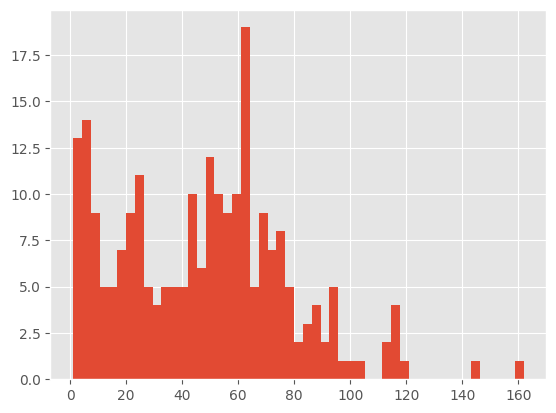

In [71]:
# Verify connectivity
print(f"Is the graph fully connected: {nx.is_connected(G)}\n")

# Network statistics
print(f"Number of nodes: \t{G.nodes().__len__()}")
print(f"Number of edges: \t{G.edges().__len__()}")
print(f"Network diameter: \t{nx.diameter(G)}")
print(f"Average shortest path: \t{nx.average_shortest_path_length(G):.4f}")

# Degree distribution
plt.hist(dict(G.degree()).values(), bins=51)
plt.show()

In [72]:
# Other statistics
clustering_coefficient  = nx.clustering(G)
degree_centrality       = nx.degree_centrality(G)
betweenness_centrality  = nx.betweenness_centrality(G)
closeness_centrality    = nx.closeness_centrality(G)
eigenvector_centrality  = nx.eigenvector_centrality(G)
density                 = nx.density(G)

## Visualize the FakeNewsNet PolitiFact graph

100%|██████████| 2/2 [00:00<00:00, 1977.98it/s]


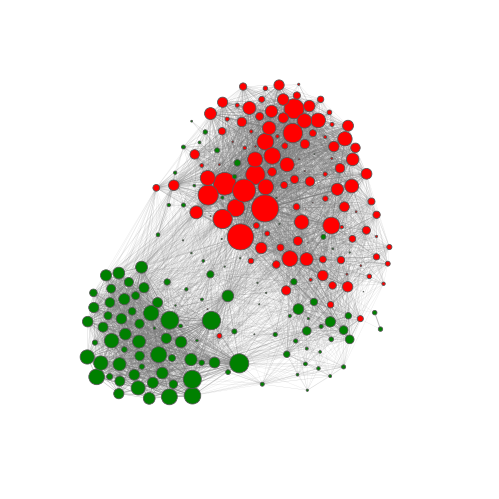

In [73]:
# Create ground truth partition
colors = ['green', 'red']
fakenews_partition = [{node for node in G.nodes() if target in node} for target in ['Real', 'Fake']]

# Retrieve color codes on the node level
viz_partition = {}
for i, partition_ in enumerate(tqdm(fakenews_partition)):
    for node_ in partition_:
        viz_partition[node_] = colors[i]

# Set color codes on the node level
nx.set_node_attributes(G, viz_partition, "group")

# Visualize network
stylized_network, config = nw.visualize(G)
fig, ax = nw.draw_netwulf(stylized_network)
plt.show()

### Clustering - Louvain method

In [19]:
# Apply Louvain method for detecting best partition of the graph
louvain_partition       = nx.community.louvain_communities(G)
modularity              = nx.community.modularity(G, louvain_partition)
print(modularity)

0.4922751097543049


100%|██████████| 6/6 [00:00<00:00, 11803.86it/s]


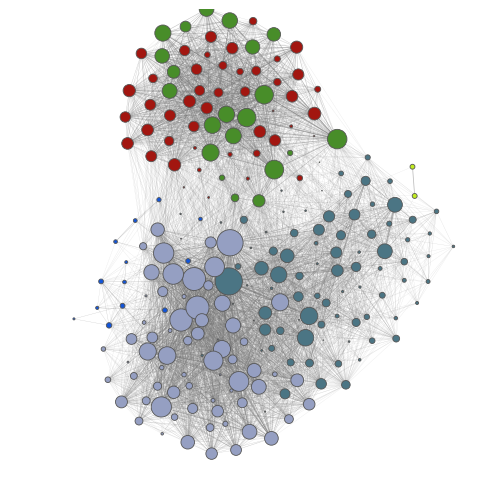

In [20]:
colors = [f"C{i}" for i in range(louvain_partition.__len__())]

# Retrieve color codes on the node level
viz_partition = {}
for i, partition_ in enumerate(tqdm(louvain_partition)):
    for node_ in partition_:
        viz_partition[node_] = colors[i]

# Set color codes on the node level
nx.set_node_attributes(G, viz_partition, "group")

# Visualize network
stylized_network, config = nw.visualize(G)
fig, ax = nw.draw_netwulf(stylized_network)
plt.show()

In [21]:
# from networkx.algorithms.community import girvan_newman
# communities = list(girvan_newman(G))